# Project: Brazilian experiment Data Analysis 
By Ali AMIN

Football          1<br>
Series               2<br>
Animals           3<br>
Entertainment     4<br>
Documentary       5<br>
Science           6<br>
Music

<h1>Session feedback</h1>



On a scale of 0 to 5 what is your interest in the content of video 1 (regardless of failures)?<br>
<br>
What about video 2 (regardless of faults)??<br>
<br>
What was your favorite video considering the quality flaws??<br>
<br>
Why did you prefer this video??<br>
<br>
On a scale of 0 to 5 what was your annoyance with interruptions in the worst quality video??<br>
<br>
Comments on the session (Optional). Was there entertainment during the session? Any other comments?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
qos_data = pd.read_csv('QoS.csv')
qos_data_init = qos_data.drop(qos_data.columns[[0, 2, 3, 4, 5, 9, 10, 11, 12, 13, 15, 16]], axis=1) 

print(qos_data_init.info())
qos_data_init.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 7 columns):
Session            1031 non-null int64
Annoyance          1031 non-null int64
intLowQoS          1031 non-null int64
intHighQoS         1031 non-null int64
Preferred_video    1031 non-null int64
Stress             1031 non-null int64
Dif_interests      1031 non-null int64
dtypes: int64(7)
memory usage: 56.5 KB
None


,Session,Annoyance,intLowQoS,intHighQoS,Preferred_video,Stress,Dif_interests
0,1,1,3,1,1,7,2
1,6,3,5,3,1,7,2
2,2,4,4,1,1,7,3
3,5,3,4,4,2,7,0
4,1,5,2,2,2,10,0


In [53]:
qos_data = qos_data_init.sort_values(by=['Session'],ascending=[True],axis=0)

qos_data_stats = qos_data.groupby("Session").describe().T

stats = qos_data.groupby("Session").describe()
stats.to_csv('./Statistics1.csv')

In [54]:
qos_data_stats

Session                         1           2           3           4  \
Annoyance       count  155.000000  124.000000  141.000000  159.000000   
                mean     3.716129    3.483871    3.290780    3.534591   
                std      1.210103    1.405471    1.411883    1.241579   
                min      0.000000    0.000000    0.000000    0.000000   
                25%      3.000000    2.000000    2.000000    3.000000   
                50%      4.000000    4.000000    4.000000    4.000000   
                75%      5.000000    5.000000    4.000000    5.000000   
                max      5.000000    5.000000    5.000000    5.000000   
Dif_interests   count  155.000000  124.000000  141.000000  159.000000   
                mean     0.703226    0.362903    0.808511    0.635220   
                std      1.554943    1.375362    1.878126    1.729935   
                min     -5.000000   -3.000000   -4.000000   -4.000000   
                25%      0.000000    0.000000    0.000000    0.000000   
                50%      0.000000    0.000000    1.000000    1.000000   
                75%      2.000000    1.000000    2.000000    2.000000   
                max      5.000000    5.000000    5.000000    5.000000   
Preferred_video count  155.000000  124.000000  141.000000  159.000000   
                mean     1.554839    1.661290    1.460993    1.534591   
                std      0.511452    0.475191    0.500253    0.500378   
                min      0.000000    1.000000    1.000000    1.000000   
                25%      1.000000    1.000000    1.000000    1.000000   
                50%      2.000000    2.000000    1.000000    2.000000   
                75%      2.000000    2.000000    2.000000    2.000000   
                max      2.000000    2.000000    2.000000    2.000000   
Stress          count  155.000000  124.000000  141.000000  159.000000   
                mean     7.019355    6.814516    6.737589    6.767296   
                std      2.331242    2.551476    2.542904    2.387189   
                min      0.000000    0.000000    0.000000    0.000000   
                25%      6.000000    5.000000    5.000000    5.000000   
                50%      8.000000    7.000000    7.000000    7.000000   
                75%      9.000000    9.000000    9.000000    8.000000   
                max     10.000000   10.000000   10.000000   10.000000   
intHighQoS      count  155.000000  124.000000  141.000000  159.000000   
                mean     2.451613    2.895161    2.134752    2.509434   
                std      1.612426    1.518550    1.512896    1.363484   
                min      0.000000    0.000000    0.000000    0.000000   
                25%      1.000000    2.000000    1.000000    1.500000   
                50%      2.000000    3.000000    2.000000    3.000000   
                75%      4.000000    4.000000    3.000000    3.000000   
                max      5.000000    5.000000    5.000000    5.000000   
intLowQoS       count  155.000000  124.000000  141.000000  159.000000   
                mean     3.154839    3.258065    2.943262    3.144654   
                std      1.604142    1.324386    1.515506    1.358687   
                min      0.000000    0.000000    0.000000    0.000000   
                25%      2.000000    2.750000    2.000000    2.000000   
                50%      3.000000    3.000000    3.000000    3.000000   
                75%      4.500000    4.000000    4.000000    4.000000   
                max      5.000000    5.000000    5.000000    5.000000   

Session                         5           6           7  
Annoyance       count  141.000000  146.000000  165.000000  
                mean     3.609929    3.328767    3.793939  
                std      1.377228    1.324098    1.304294  
                min      0.000000    0.000000    0.000000  
                25%      3.000000    2.000000    3.000000  
                50%      4.000000    3.000000    4.000000  
  

             mean      mean
Session                    
1        2.451613  3.154839
2        2.895161  3.258065
3        2.134752  2.943262
4        2.509434  3.144654
5        3.042553  3.078014
6        3.034247  3.945205
7        3.181818  3.545455


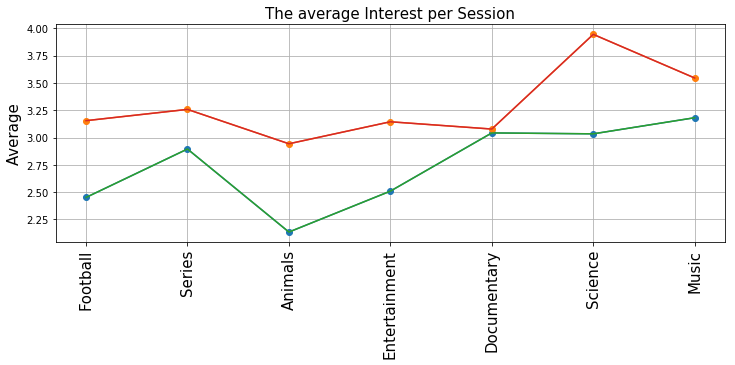

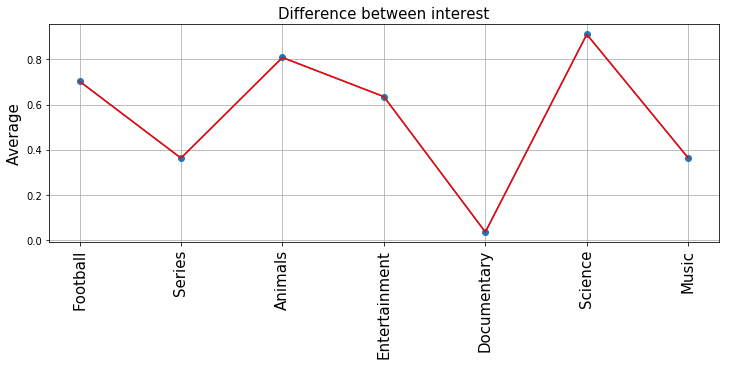

In [55]:
Annoy_mean = qos_data_stats.loc['Annoyance'].loc['mean']
Dif_LH_mean = qos_data_stats.loc['Dif_interests'].loc['mean']
HQ_mean = qos_data_stats.loc['intHighQoS'].loc['mean']
LQ_mean = qos_data_stats.loc['intLowQoS'].loc['mean']
Stress_mean = qos_data_stats.loc['Stress'].loc['mean']
Fav_mean = qos_data_stats.loc['Preferred_video'].loc['mean']

Annoy_std = qos_data_stats.loc['Annoyance'].loc['std']
Dif_LH_std = qos_data_stats.loc['Dif_interests'].loc['std']
HQ_std = qos_data_stats.loc['intHighQoS'].loc['std']
LQ_std = qos_data_stats.loc['intLowQoS'].loc['std']
Stress_std = qos_data_stats.loc['Stress'].loc['std']
Fav_std = qos_data_stats.loc['Preferred_video'].loc['std']


list_of_series_Mean = [ HQ_mean, LQ_mean]
list_of_series_Std= [ HQ_std, LQ_std]


Mean = pd.DataFrame(list_of_series_Mean).T
Std = pd.DataFrame(list_of_series_Std).T


print(Mean)

plt.figure(figsize = (12,4))
plt.grid(True)
plt.title("The average Interest per Session",fontsize = 15)
# plt.xlabel("Sessions",fontsize = 15)
plt.ylabel("Average",fontsize = 15)
plt.plot(Mean["mean"] ,'-o')
plt.xticks(np.arange(1,8),['Football', 'Series', 'Animals', 'Entertainment', 'Documentary', 'Science', 'Music'],fontsize=15,rotation='vertical')
plt.plot(Mean)



plt.figure(figsize = (12,4))
plt.grid(True)
plt.title("Difference between interest",fontsize = 15)
# plt.xlabel("Sessions",fontsize = 15)
plt.ylabel("Average",fontsize = 15)
plt.plot(Dif_LH_mean ,'-o')


plt.xticks(np.arange(1,8),['Football', 'Series', 'Animals', 'Entertainment', 'Documentary', 'Science', 'Music'],fontsize=15,rotation='vertical')
plt.plot(Dif_LH_mean, color = 'r')

By visualising the Mean average of the 

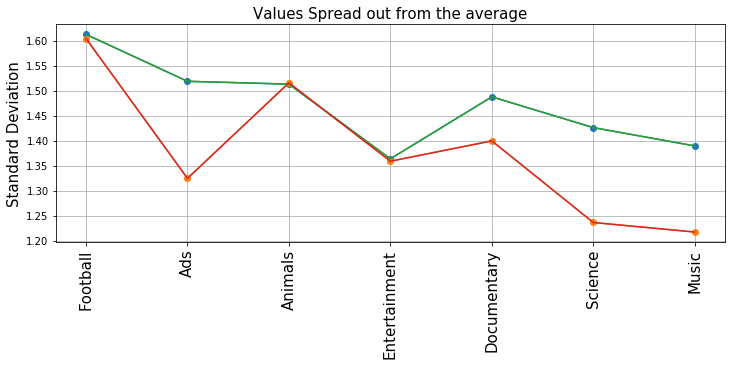

In [56]:
plt.figure(figsize = (12,4))
plt.grid(True)
plt.title("Values Spread out from the average",fontsize = 15)
plt.ylabel("Standard Deviation",fontsize = 15)
plt.plot(Std["std"] ,'-o')
plt.xticks(np.arange(1,8),['Football', 'Ads', 'Animals', 'Entertainment', 'Documentary', 'Science', 'Music'],fontsize=15,rotation='vertical')
plt.plot(Std)


<b>Standard deviation</b> is a number used to tell how measurements for a group are spread out from the average (mean), or expected value. A low standard deviation means that most of the numbers are very close to the average. A high standard deviation means that the numbers are spread out.

In [64]:
df = qos_data_init.groupby("Preferred_video").count().T
df


Preferred_video,0,1,2
Session,1,453,577
Annoyance,1,453,577
intLowQoS,1,453,577
intHighQoS,1,453,577
Stress,1,453,577
Dif_interests,1,453,577


In [69]:
df = qos_data_init.groupby("intHighQoS").count().T
df


intHighQoS,0,1,2,3,4,5
Session,88,156,189,242,204,152
Annoyance,88,156,189,242,204,152
intLowQoS,88,156,189,242,204,152
Preferred_video,88,156,189,242,204,152
Stress,88,156,189,242,204,152
Dif_interests,88,156,189,242,204,152


In [66]:
df = qos_data_init.groupby("intLowQoS").count().T
df

intLowQoS,0,1,2,3,4,5
Session,48,91,130,230,298,234
Annoyance,48,91,130,230,298,234
intHighQoS,48,91,130,230,298,234
Preferred_video,48,91,130,230,298,234
Stress,48,91,130,230,298,234
Dif_interests,48,91,130,230,298,234


In [67]:
df = qos_data_init.groupby("Stress").count().T
df

Stress,0,1,2,3,4,5,6,7,8,9,10
Session,18,27,30,47,47,102,86,158,265,141,110
Annoyance,18,27,30,47,47,102,86,158,265,141,110
intLowQoS,18,27,30,47,47,102,86,158,265,141,110
intHighQoS,18,27,30,47,47,102,86,158,265,141,110
Preferred_video,18,27,30,47,47,102,86,158,265,141,110
Dif_interests,18,27,30,47,47,102,86,158,265,141,110


In [68]:
df = qos_data_init.groupby("Annoyance").count().T
df

Annoyance,0,1,2,3,4,5
Session,28,54,144,216,280,309
intLowQoS,28,54,144,216,280,309
intHighQoS,28,54,144,216,280,309
Preferred_video,28,54,144,216,280,309
Stress,28,54,144,216,280,309
Dif_interests,28,54,144,216,280,309
